In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cPickle, sys, os
from subprocess import Popen, PIPE
import seaborn as sns

In [3]:
# This analysis has been ported to the script that parallelizes it
# analysisOutput_MPI.py

In [4]:
rrr = cPickle.load(open("resultsTOT_ALL_MPI_clustTriangsNusBetas_-home-ubi-urns-out-.pkl", "rb"))
rrr = cPickle.load(open("resultsTOT_ALL_MPI_FINAL_-home-ubi-urns_serie-out-.pkl", "rb"))

In [5]:
len(rrr)

2

In [6]:
import pandas as pd

In [7]:
selCols =  ["A_e", "A_c", "D_c", "D_e", "F_c", "F_e", "p_to_f",
            "run_idx", "Ev_Steps", "k_a_t", "beta_opt", "Fa_nu", "Fk_mu",
            "new-close", "old-close", "new-open", "old-open", "clust_t",
            
           ]
df = pd.DataFrame.from_dict({(son, exc, rat, rho):
        {k: rhoD[k][i] if k!="k_a_t" else rhoD[k][i][2] for k in selCols}
                  for son, sonD in rrr.iteritems()
                   for exc, excD in sonD.iteritems()
                    for rat, ratD in excD.iteritems()
                     for rho, rhoD in ratD.iteritems()
                      for i in range(len(rhoD["Ev_Steps"]))
                }, orient="index", columns=selCols)

In [8]:
df.index.names = ["son", "exc", "rat", "rho"]
df.head()

A_e       A_c       D_c       D_e        F_c       F_e  \
son exc rat rho                                                                
0   0   0.2 1.0  0.998946  791500.0  259100.0  0.991046  1980000.0  0.991046   
            2.0  0.999799  824600.0  317500.0  0.996771  2295000.0  0.996771   
            3.0  1.001180  835400.0  341600.0  0.999466  2437000.0  0.999466   
            4.0  0.999708  841800.0  355800.0  0.997657  2512000.0  0.997657   
            5.0  0.998620  843900.0  362700.0  0.999039  2602000.0  0.999039   

                   p_to_f  run_idx  Ev_Steps     k_a_t  beta_opt     Fa_nu  \
son exc rat rho                                                              
0   0   0.2 1.0  0.399913        7    500000  0.568770      0.12  2.281036   
            2.0  0.385692        9    500000  0.524580      0.10  2.327355   
            3.0  0.372067        5    500000  0.513069      0.09  2.350443   
            4.0  0.364290        3    500000  0.494789      0.09  2.363865   
            5.0  0.364780        7    500000  0.489427      0.09  2.368170   

                    Fk_mu  new-close  old-close  new-open  old-open   clust_t  
son exc rat rho                                                                
0   0   0.2 1.0  2.391114   0.157588   0.080508  0.633584  0.128320  0.084733  
            2.0  2.469443   0.103946   0.047917  0.720336  0.127802  0.057236  
            3.0  2.504920   0.084548   0.037624  0.751262  0.126565  0.047202  
            4.0  2.527382   0.073907   0.031008  0.767890  0.127195  0.042145  
            5.0  2.541204   0.067956   0.029873  0.775332  0.126839  0.039628

In [9]:
import pickle
if False:
    pickle.dump(ResultsTot, open("resultsTOT_ALL_DEFINITIVE_" + IDIr.replace("/", "-") + ".pkl", "wb"))
else:
    ResultsTot = pickle.load(open("resultsTOT_ALL_DEFINITIVE_-home-ubi-urns-data_analyzed-.pkl", "rb"))
    ResultsTot = pickle.load(open("resultsTOT_ALL_MPI_FINAL_-home-ubi-urns_serie-out-.pkl", "rb"))

## Aux functions

In [10]:
Nu = lambda r: r/ratio

from scipy.optimize import curve_fit
def generic_fit_foo(x, a, b, c):
    return a + b * x**c

def generic_fit_foo_ln(x, a, b, c):
    return a + b * (x**c)

def pars2string(pars):
    names = ["a", "b", "c"]
    return "\n".join(r"$%s = %.02f$" % (l,k)
                     for l,k in zip(names, pars))

#p_fath = lambda r: 1./3. + .25/Nu(r)

#f_fath = lambda r: 3. - 1.75/Nu(r)**.75 # 3. - 2./Nu(r)

p_fath = lambda r: AconstP + BconstP * (Nu(r)**CconstP)
f_fath = lambda r: AconstF + BconstF * (Nu(r)**CconstF)

#nu_tilde = lambda r: 1./ratio

a_fact = lambda r: Nu(r) + 1. - p_fath(r)

b_fact = lambda r: Nu(r) + f_fath(r)# - nu_tilde(r) # CHECK WHY THIS ONE IS MISSING

c_fact = lambda r: 2.*r

Qtilde = lambda r: a_fact(r)/b_fact(r)

Mtilde = lambda r:b_fact(r)/c_fact(r)

AAA = lambda r: 2.*r

BBB = lambda r: 2.*Nu(r) + 2.*r*Mtilde(r) + 1. - f_fath(r) - p_fath(r)

CCC = lambda r: Mtilde(r) * (p_fath(r) - Nu(r) + (Nu(r) + 1. - f_fath(r))*Qtilde(r))

Gamma  = lambda r: (BBB(r) + np.sqrt( (BBB(r)**2.) + 4.*AAA(r)*CCC(r) ))/(4.*r)

Gamma_asympt = lambda r: r/r*Gamma(1000)

## $A(t), D(t), F(t)$ proportionality constants and probabilities evolution

In [11]:
sonexch2strat = {
    (0,0): "s=WS",
    (0,1): "s=WSW",
    (0,2): "s=USW",
    (1,0): "s=FS",
    (1,1): "s=ASW",
    (1,2): "s=SSW",
}

In [12]:
# Once for all...
# Leave empty to do all...
selectedRatios = (.5, 2./3, .75, .8, 1., 5./4., 4./3., 1.5, 1.75, 2., 2.5, 3., 3.5)#, 4.)

In [13]:
from scipy.optimize import leastsq

/usr/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


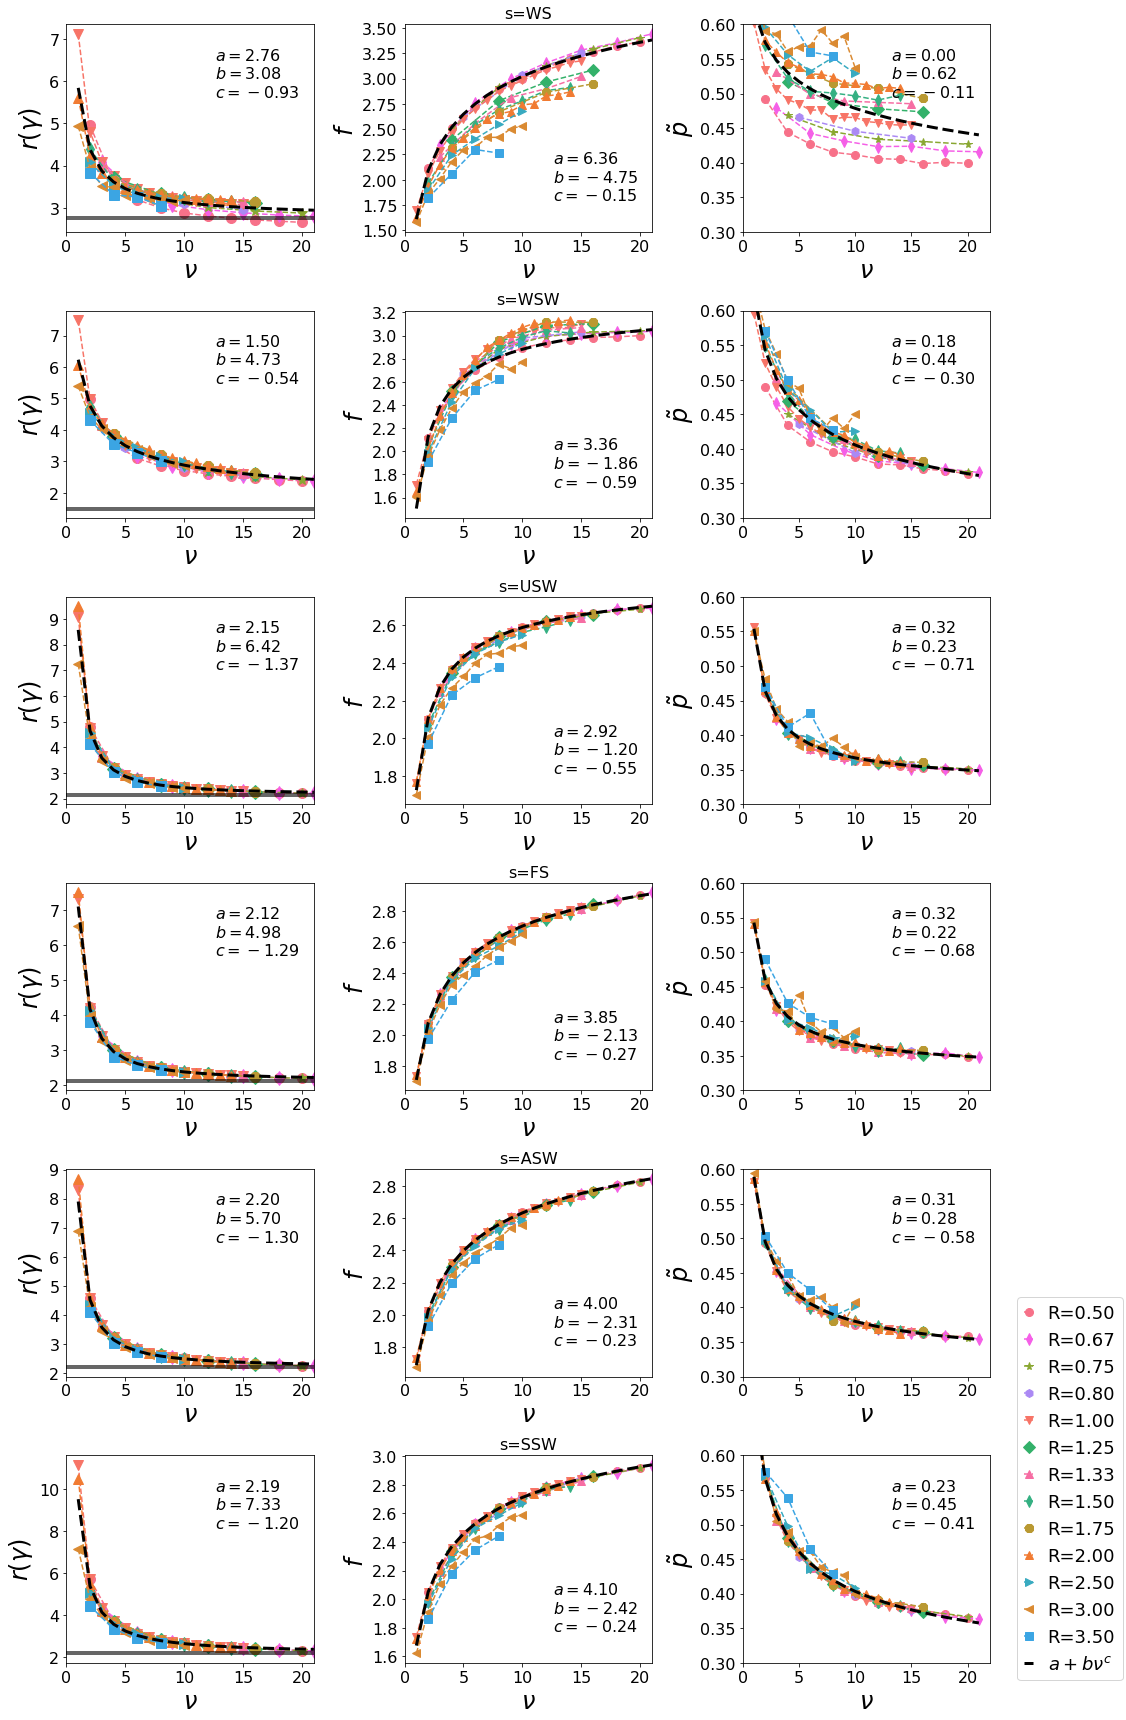

In [14]:
# Leave empty to do all...
#selectedRatios = (4./3., 1.5, 1.75, 2., 2.5, 3., 4., 5.)
#selectedSonSchemes = (1,)
#selectedExcSchemes = (0,)
smallTime, largeTime = 100000, 1000000
rhos_theo = np.arange(2, 50)

nRows, nCols = 6, 3
fig = plt.figure(figsize=(4*(nCols+.5), 4*nRows))

allRatios = set()
for sonExch, sonResults in sorted(ResultsTot.iteritems()):
    for sampleStrat, Results in sorted(sonResults.iteritems()):
        allRatios.update(Results.keys())

paletta = sns.color_palette("husl", len(allRatios))
colors  = [paletta[i] for i in  range(len(allRatios))]
markers = 'ov^<>8sp*hHDd'

colors  = {r: c for r, c in zip(allRatios, colors)}
markers = {r: markers[i%len(markers)] for i, r in enumerate(allRatios)}

f_r_p_params = {}
measuredConstants = {}
for sonExch, sonResults in sorted(ResultsTot.iteritems()):
    #if selectedSonSchemes and sonExch not in selectedSonSchemes: continue
    measuredConstants[sonExch] = {}
    for sampleStrat, Results in sorted(sonResults.iteritems()):
        #if selectedExcSchemes and sampleStrat not in selectedExcSchemes: continue
        measuredConstants[sonExch][sampleStrat] = {k: {"x": [], "y": [], "s": []}
                                                   for k in ["r_gamma", "f", "p_fath"]}
        First=True
        for curv_n, [ratio, res] in enumerate(sorted(Results.items())):
            if selectedRatios and ratio not in selectedRatios: continue
            subplot_index = (sonExch*3)*nCols + sampleStrat*nCols + 1

            rhos = np.array([k for k in sorted(res.keys())])
            D_exps = np.array([sum(res[k]['D_c'])/float(len(res[k]['D_c'])) for k in sorted(res.keys())])
            A_exps = np.array([sum(res[k]['A_c'])/float(len(res[k]['A_c'])) for k in sorted(res.keys())])
            F_exps = np.array([sum(res[k]['F_c'])/float(len(res[k]['F_c'])) for k in sorted(res.keys())])
            p_to_f = np.array([sum(res[k]['p_to_f'])/float(len(res[k]['p_to_f'])) for k in sorted(res.keys())])

            riferimento = np.array(D_exps)
            D_exps /= riferimento
            F_exps /= A_exps
            A_exps /= riferimento
            #F_exps /= riferimento

            #plt.plot(rhos, D_exps, linestyle='--', color='k', ms=12, label="%.01f"%ratio, marker=markers[curv_n%len(markers)])
            plt.subplot(nRows,nCols,subplot_index)
            XXXs = rhos/ratio
            YYYs = A_exps
            measuredConstants[sonExch][sampleStrat]["r_gamma"]["x"].extend(XXXs)
            measuredConstants[sonExch][sampleStrat]["r_gamma"]["y"].extend(YYYs)
            plt.plot(XXXs, YYYs,
                     label=r"$R=%.02f$"%ratio,
                     linestyle='--', color=colors[ratio], ms=10,
                     marker=markers[ratio])

            rhos = np.array(rhos)
            Gamma  = lambda r: (BBB(r) + np.sqrt( BBB(r)**2. + 4.*AAA(r)*CCC(r) ))/(4.*r)
            Omega = lambda r: (Gamma(r) + Mtilde(r)*Qtilde(r))/(Gamma(r) - Mtilde(r))

            plt.subplot(nRows,nCols,subplot_index+1)
            plt.title(r"%s" % sonexch2strat[(sonExch, sampleStrat)], size=16)
            XXXs = rhos/ratio
            YYYs = F_exps
            measuredConstants[sonExch][sampleStrat]["f"]["x"].extend(XXXs)
            measuredConstants[sonExch][sampleStrat]["f"]["y"].extend(YYYs)
            measuredConstants[sonExch][sampleStrat]["f"]["s"].extend([ratio]*len(XXXs))
            plt.plot(XXXs, YYYs,
                     label=r"$R=%.02f$"%ratio,
                     linestyle='--', color=colors[ratio], ms= 8,
                     marker=markers[ratio])

            plt.subplot(nRows,nCols,subplot_index+2)
            XXXs = rhos/ratio
            YYYs = p_to_f
            measuredConstants[sonExch][sampleStrat]["p_fath"]["x"].extend(XXXs)
            measuredConstants[sonExch][sampleStrat]["p_fath"]["y"].extend(YYYs)
            plt.plot(XXXs, YYYs, linestyle='--', color=colors[ratio],
                     ms=8, label="R=%.02f"%ratio, marker=markers[ratio])
        
        xMAX = 22
        nnn = np.arange(1, xMAX)

        ax = plt.subplot(nRows,nCols,subplot_index)
        XXXs = np.array(measuredConstants[sonExch][sampleStrat]["r_gamma"]["x"])
        YYYs = np.array(measuredConstants[sonExch][sampleStrat]["r_gamma"]["y"])
        res, cov = curve_fit(generic_fit_foo, XXXs, YYYs, p0=[2., 1., -1.],
                             bounds=((1e-3, 1e-3, -3.), (10., 10., 3.)))
        f_r_p_params.setdefault(sonExch, {})
        f_r_p_params[sonExch].setdefault(sampleStrat, {})
        f_r_p_params[sonExch][sampleStrat]["r"] = res
        
        plt.plot(nnn, generic_fit_foo(nnn, *res), '--k', lw=3) # Factor
        plt.plot(np.arange(xMAX), res[0]*np.ones(xMAX),\
            linestyle='-', lw=4, color="k", alpha=.6)
        plt.text(.6, .65, pars2string(res), transform=ax.transAxes, size=16)

        plt.xlabel(r"$\nu$", size=24)
        plt.ylabel(r"$r(\gamma)$", size=24)
        plt.xticks(size=16)
        plt.yticks(size=16)
        plt.xlim(0, xMAX-1)

        ax = plt.subplot(nRows,nCols,subplot_index+1)
        XXXs = np.array(measuredConstants[sonExch][sampleStrat]["f"]["x"])
        YYYs = np.array(measuredConstants[sonExch][sampleStrat]["f"]["y"])
        SSSs = np.array(measuredConstants[sonExch][sampleStrat]["f"]["s"])
        res, cov = curve_fit(generic_fit_foo_ln, XXXs, YYYs, sigma=(YYYs**.5 * SSSs**2.5),
            p0=[2., -1., -1.], bounds=((-7.5, -4.75, -3.), (7.5, 1e-3, 3.)), maxfev=50000)
        f_r_p_params[sonExch][sampleStrat]["f"] = res
        
        plt.plot(nnn, generic_fit_foo(nnn, *res), '--k', lw=3) # fath Factor
        # plt.plot(np.arange(xMAX), res[0]*np.ones(xMAX),\
        #     linestyle='-', lw=4, color="k", alpha=.6)
        plt.text(.6, .15, pars2string(res), transform=ax.transAxes, size=16)
        # plt.plot(nnn, 3. - 1.75/nnn**.75, '--k', lw=3) # fath factor
        
        plt.xlabel(r"$\nu$", size=24)
        plt.ylabel(r"$f$", size=24)
        plt.xticks(size=16)
        plt.yticks(size=16)
        plt.xlim(0, xMAX-1)
        
        ax = plt.subplot(nRows,nCols,subplot_index+2)
        XXXs = np.array(measuredConstants[sonExch][sampleStrat]["p_fath"]["x"])
        YYYs = np.array(measuredConstants[sonExch][sampleStrat]["p_fath"]["y"])
        res, cov = curve_fit(generic_fit_foo, XXXs, YYYs, p0=[2., 1., -1.],
                             bounds=((1e-3, 1e-3, -3.), (10., 10., 3.)))
        f_r_p_params[sonExch][sampleStrat]["p"] = res
        
        plt.plot(nnn, generic_fit_foo(nnn, *res), '--k', lw=3, label=r"$a+b\nu^c$") # fath Factor
        # plt.plot(np.arange(xMAX), res[0]*np.ones(xMAX),\
        #     linestyle='-', lw=4, color="k", alpha=.6)
        plt.text(.6, .65, pars2string(res), transform=ax.transAxes, size=16)
        # plt.plot(nnn, 1./3. + .25/nnn, '--k', lw=3)

        plt.xlabel(r"$\nu$", size=24)
        plt.ylabel(r"$p_{\rm father}$", size=24)
        plt.ylabel(r"$\tilde p$", size=24)
        plt.ylim(.3, .6)
        plt.xlim(0,xMAX)
        plt.xticks(size=16)
        plt.yticks(size=16)
        
handles, labels = ax.get_legend_handles_labels()
lgd = plt.figlegend(handles, labels, fontsize=18, numpoints=1, loc="upper left", ncol=1,
           bbox_to_anchor=[1, .25], handlelength=.5)
#plt.legend(fontsize=18, numpoints=1, ncol=1, bbox_to_anchor=[1,1], loc="upper left")

plt.tight_layout()
plt.savefig("fig_Constants.pdf", bbox_inches='tight')
plt.savefig("fig_Constants.png", bbox_inches='tight', dpi=300)

In [15]:
f_r_p_params[1][0]

{'f': array([ 3.84573119, -2.13259604, -0.27125077]),
 'p': array([ 0.31982381,  0.22290225, -0.67825816]),
 'r': array([ 2.12263513,  4.98256728, -1.28500833])}

In [16]:
pickle.dump(f_r_p_params, open("f_r_params.pkl", "wb"))

In [17]:
#measuredConstants[1][0]

## $\gamma$ exponent case by case

In [18]:
# Once for all...
# Leave empty to do all...
selectedRatios = (.5, 2./3, .75, .8, 1., 5./4., 4./3., 1.5, 1.75, 2., 2.5, 3., 3.5)#, 4.)

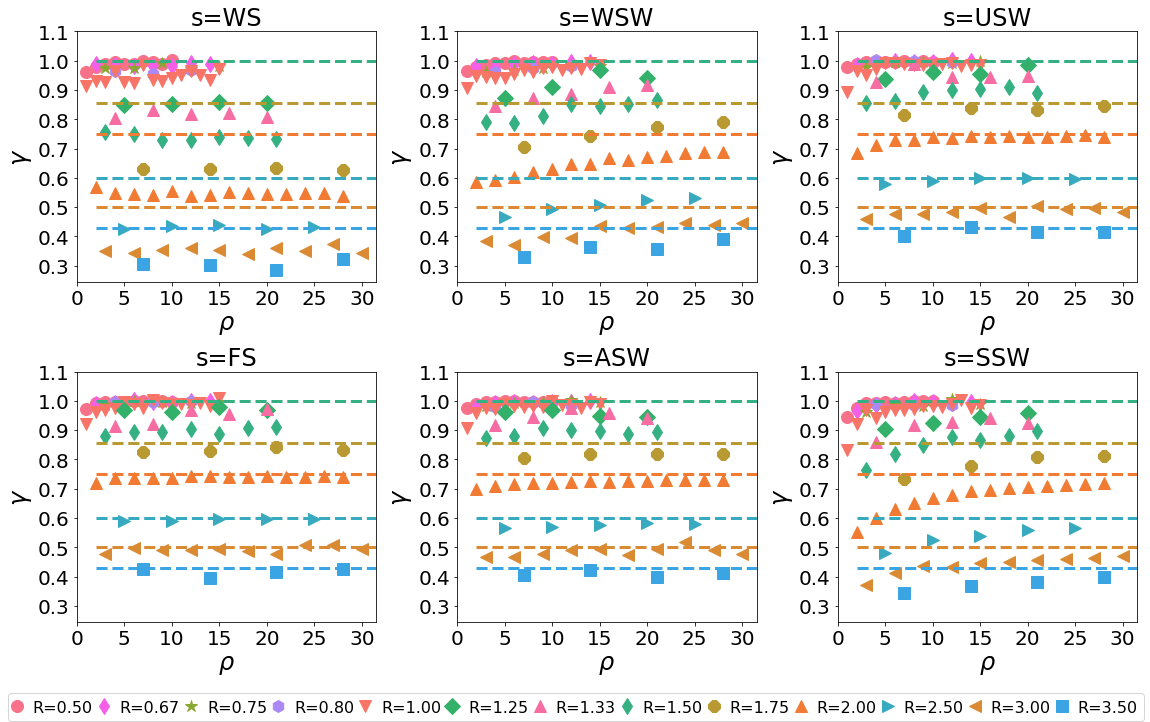

In [19]:
markers="so^*x8pd4"
colors = "rgkcby"

# Plot the average or the longest time?
plotAverage = False
# Weight proportional to elapsed time
averageWeighted = False

file_prefix = "ratios_%s_average%d_weighted%d" %\
                    ("%d"%len(selectedRatios) if selectedRatios else "all",
                     plotAverage, averageWeighted)

rhos_theo = np.arange(2, 50)

nRows, nCols = len(ResultsTot), len(ResultsTot[0])

fig = plt.figure(figsize=(5*(nCols)+1, 5*nRows))

allRatios = set()
for sonExch, sonResults in sorted(ResultsTot.iteritems()):
    for sampleStrat, Results in sorted(sonResults.iteritems()):
        allRatios.update(Results.keys())

paletta = sns.color_palette("husl", len(allRatios))
colors  = [paletta[i] for i in  range(len(allRatios))]
markers = 'ov^<>8sp*hHDd'

colors  = {r: c for r, c in zip(allRatios, colors)}
markers = {r: markers[i%len(markers)] for i, r in enumerate(allRatios)}

for sonExch, sonResults in sorted(ResultsTot.iteritems()):
    for sampleStrat, Results in sorted(sonResults.iteritems()):
        f_r_p_params
        ax = fig.add_subplot(nRows, nCols, sonExch*nCols+sampleStrat+1)

        for curv_n, [ratio, res] in enumerate(sorted(Results.items())):
            if selectedRatios and ratio not in selectedRatios: continue
            
            # Update the constants to compute f and p...
            AconstF, BconstF, CconstF =  tuple(f_r_p_params[sonExch][sampleStrat]["f"])
            AconstP, BconstP, CconstP =  tuple(f_r_p_params[sonExch][sampleStrat]["p"])
                
            rhos = [k for k in sorted(res.keys())]
            
            if plotAverage:
                if averageWeighted:
                    nTimes = np.array([float(len(res[k]['Ev_Steps'])) for k in rhos])
                    weights = [np.array(res[k]['Ev_Steps']) for k in rhos]
                else:
                    nTimes = np.array([float(len(res[k]['D_e'])) for k in rhos])
                    weights = [np.ones(len(res[k]['Ev_Steps'])) for k in rhos]
                positionsIni = np.zeros(len(rhos), dtype=np.int)
                positionsFin = np.array(nTimes, dtype=np.int)
            else:
                nTimes = np.array([1 for _ in rhos])
                weights = [np.ones(1) for _ in nTimes]
                positionsIni = np.array([np.argmax(np.array(res[k]['Ev_Steps'])) for k in rhos], dtype=np.int)
                positionsFin = positionsIni + 1
            weightsSum = [np.sum(ws) for ws in weights]
                
                
            D_exps = np.array([np.sum(np.array(res[k]['D_e'][positionsIni[i]:positionsFin[i]])*weights[i])/weightsSum[i] for i,k in enumerate(rhos)])
            A_exps = np.array([np.sum(np.array(res[k]['A_e'][positionsIni[i]:positionsFin[i]])*weights[i])/weightsSum[i] for i,k in enumerate(rhos)])
            F_exps = np.array([np.sum(np.array(res[k]['F_e'][positionsIni[i]:positionsFin[i]])*weights[i])/weightsSum[i] for i,k in enumerate(rhos)])
            D_const = np.array([np.sum(np.array(res[k]['D_c'][positionsIni[i]:positionsFin[i]])*weights[i])/weightsSum[i] for i,k in enumerate(rhos)])
            A_const = np.array([np.sum(np.array(res[k]['A_c'][positionsIni[i]:positionsFin[i]])*weights[i])/weightsSum[i] for i,k in enumerate(rhos)])
            F_const = np.array([np.sum(np.array(res[k]['F_c'][positionsIni[i]:positionsFin[i]])*weights[i])/weightsSum[i] for i,k in enumerate(rhos)])

            riferimento = np.array(D_const)
            D_const /= riferimento
            F_const /= A_const
            A_const /= riferimento

            p_to_f = np.array([sum(res[k]['p_to_f'])/float(len(res[k]['p_to_f'])) for k in sorted(res.keys())])


            plt.plot(rhos, D_exps, linestyle='', color=colors[ratio], ms=12, label="R=%.02f"%ratio,\
                     marker=markers[ratio])
            #plt.plot(rhos, A_exps, linestyle='', color=colors[ratio], ms=10,\
            #         marker=markers[ratio])
            #plt.plot(rhos, F_exps, linestyle='', color=colors[ratio], ms= 8,\
            #         marker=markers[ratio])

            tmp_Rho = rhos[-1]
            tmp_Nu = tmp_Rho/ratio

            prediction = (tmp_Nu - p_to_f[-1]) + (tmp_Nu + 1 - F_const[-1])*A_const[-1]
            prediction /= 2.*tmp_Rho
            rhos = np.array(rhos)
            #plt.plot(rhos_theo, Gamma(rhos_theo), linestyle='-', color=colors[ratio])
            plt.plot(rhos_theo, Gamma_asympt(rhos_theo), lw=3, linestyle='--', color=colors[ratio])

        plt.xlabel(r"$\rho$", size=24)
        plt.ylabel(r"$\gamma$", size=24)
        plt.xticks(size=20)
        plt.yticks(size=20)

        plt.title(r"%s" % sonexch2strat[(sonExch, sampleStrat)], size=24)
        
        plt.xlim(0,31.5)
        plt.ylim(.245,1.1)

#handles, labels = ax.get_legend_handles_labels()
#lgd = plt.figlegend(handles, labels, fontsize=18, numpoints=1, loc="upper left", ncol=1,
#           bbox_to_anchor=[1, .75], handlelength=.5)
#plt.tight_layout()

handles, labels = ax.get_legend_handles_labels()
#plt.subplot(nRows, nCols, nCols)
lgd = plt.figlegend(handles, labels, fontsize=16, numpoints=1, loc=3, ncol=len(handles),
           bbox_to_anchor=[0, -.01, 1., -.01], mode="expand", handlelength=.35)
plt.tight_layout(rect=[0, 0.04, 1, 1.])

plt.savefig("fig_gammaExponents_%s.pdf" % file_prefix, bbox_inches='tight', bbox_extra_artists=(lgd,))

In [20]:
allRatios

{0.2,
 0.25,
 0.3333333333333333,
 0.4,
 0.5,
 0.6,
 0.6666666666666666,
 0.75,
 0.8,
 1.0,
 1.2,
 1.25,
 1.3333333333333333,
 1.4,
 1.5,
 1.6666666666666667,
 1.75,
 1.8,
 2.0,
 2.25,
 2.3333333333333335,
 2.5,
 2.6666666666666665,
 2.75,
 3.0,
 3.25,
 3.5,
 3.75,
 4.0}

## $\gamma$ Exponent convergence in time

In [21]:
from scipy.stats import pearsonr

In [22]:
res[res.keys()[0]]["Ev_Steps"]

[50000000,
 50000000,
 50000000,
 50000000,
 50000000,
 50000000,
 50000000,
 50000000,
 50000000,
 50000000]

In [23]:
#res

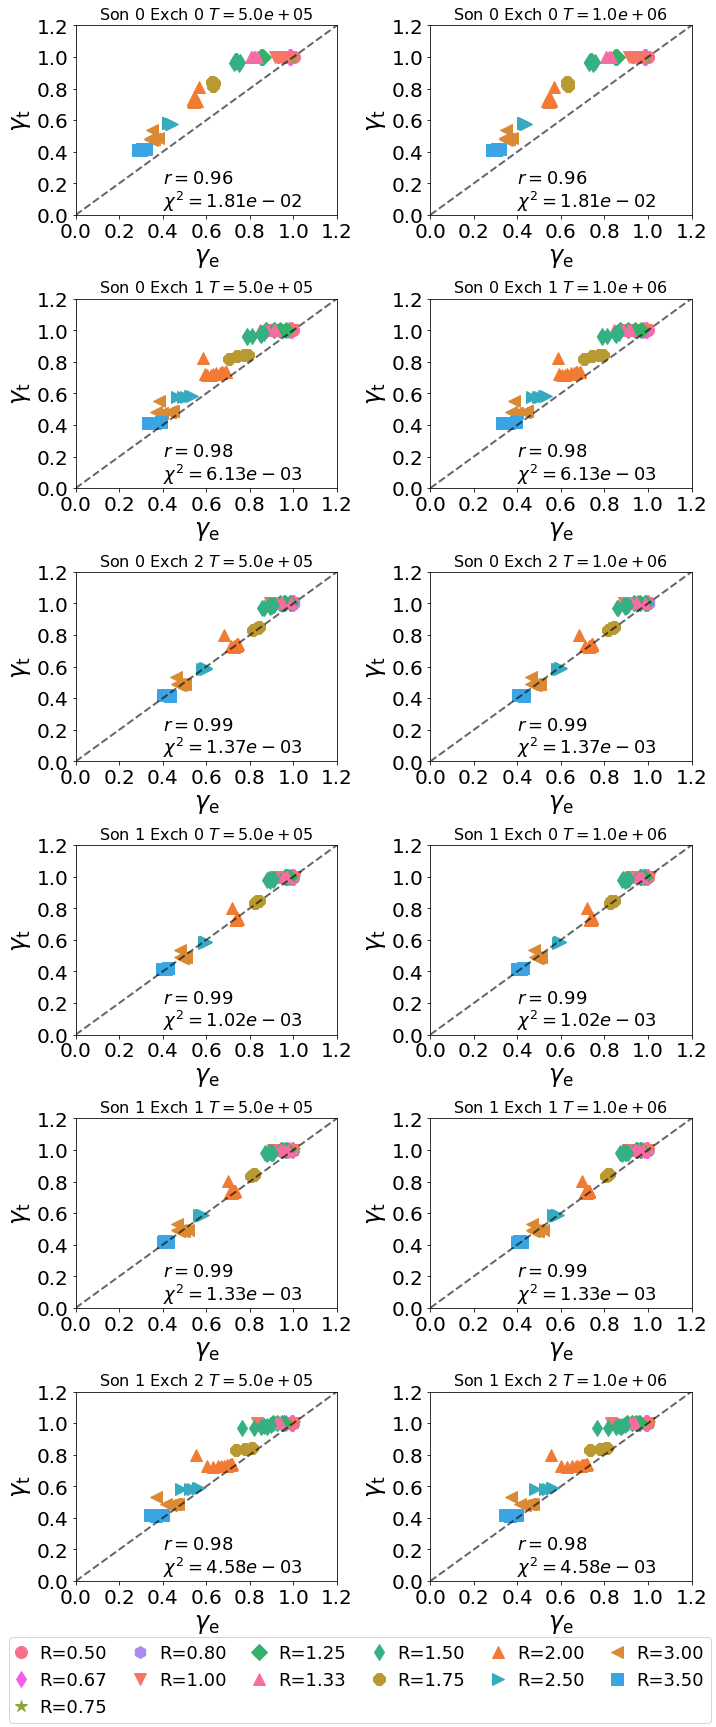

In [24]:
# Leave empty to do all...
#selectedRatios = (4./3., 1.5, 1.75, 2., 2.5, 3., 4., 5.)
#selectedSonSchemes = (1,)
#selectedExcSchemes = (0,)
smallTime, largeTime = 500000, 1000000
rhos_theo = np.arange(2, 50)

nRows, nCols = 6, 2
fig = plt.figure(figsize=(4*(nCols+.5), 4*nRows))

allRatios = set()
for sonExch, sonResults in sorted(ResultsTot.iteritems()):
    for sampleStrat, Results in sorted(sonResults.iteritems()):
        allRatios.update(Results.keys())

paletta = sns.color_palette("husl", len(allRatios))
colors  = [paletta[i] for i in  range(len(allRatios))]
markers = 'ov^<>8sp*hHDd'

colors  = {r: c for r, c in zip(allRatios, colors)}
markers = {r: markers[i%len(markers)] for i, r in enumerate(allRatios)}

for sonExch, sonResults in sorted(ResultsTot.iteritems()):
    #if selectedSonSchemes and sonExch not in selectedSonSchemes: continue
    for sampleStrat, Results in sorted(sonResults.iteritems()):
        #if selectedExcSchemes and sampleStrat not in selectedExcSchemes: continue
        
        recordedGammas = [[[], []], [[], []]]
        for curv_n, [ratio, res] in enumerate(sorted(Results.items())):
            if selectedRatios and ratio not in selectedRatios: continue
            
            # Update the constants to compute f and p...
            AconstF, BconstF, CconstF =  tuple(f_r_p_params[sonExch][sampleStrat]["f"])
            AconstP, BconstP, CconstP =  tuple(f_r_p_params[sonExch][sampleStrat]["p"])
            
            subplot_index = (sonExch*3)*nCols + sampleStrat*nCols + 1
            rhos = [k for k in sorted(res.keys())]
            for plot_index, selectedTime in enumerate([smallTime, largeTime]):
                nTimes = np.array([1 for _ in rhos])
                weights = [np.ones(1) for _ in nTimes]
                positionsIni = np.array([np.argmax(np.array(res[k]['Ev_Steps']) == selectedTime) for k in rhos],
                                        dtype=np.int)
                positionsFin = positionsIni + 1
                weightsSum = [np.sum(ws) for ws in weights]

                D_exps = np.array([np.sum(np.array(res[k]['D_e'][positionsIni[i]:positionsFin[i]])*weights[i])/weightsSum[i] for i,k in enumerate(rhos)])
                A_exps = np.array([np.sum(np.array(res[k]['A_e'][positionsIni[i]:positionsFin[i]])*weights[i])/weightsSum[i] for i,k in enumerate(rhos)])
                F_exps = np.array([np.sum(np.array(res[k]['F_e'][positionsIni[i]:positionsFin[i]])*weights[i])/weightsSum[i] for i,k in enumerate(rhos)])
                D_const =np.array([np.sum(np.array(res[k]['D_c'][positionsIni[i]:positionsFin[i]])*weights[i])/weightsSum[i] for i,k in enumerate(rhos)])
                A_const =np.array([np.sum(np.array(res[k]['A_c'][positionsIni[i]:positionsFin[i]])*weights[i])/weightsSum[i] for i,k in enumerate(rhos)])
                F_const =np.array([np.sum(np.array(res[k]['F_c'][positionsIni[i]:positionsFin[i]])*weights[i])/weightsSum[i] for i,k in enumerate(rhos)])

                riferimento = np.array(D_const)
                D_const /= riferimento
                F_const /= A_const
                A_const /= riferimento

                p_to_f = np.array([sum(res[k]['p_to_f'])/float(len(res[k]['p_to_f'])) for k in sorted(res.keys())])

                
                tmp_Rho = rhos[-1]
                tmp_Nu = tmp_Rho/ratio

                prediction = (tmp_Nu - p_to_f[-1]) + (tmp_Nu + 1 - F_const[-1])*A_const[-1]
                prediction /= 2.*tmp_Rho

                rhos = np.array(rhos)
                experimental = D_exps
                theoretical = np.array([min(1., g) for g in Gamma(rhos)])
                
                recordedGammas[plot_index][0].extend(experimental)
                recordedGammas[plot_index][1].extend(theoretical)
                
                plt.subplot(nRows, nCols, subplot_index + plot_index)
                plt.title(r"Son %s Exch %d $T = %.01e$" % (sonExch, sampleStrat, selectedTime), size=16)
                plt.plot(experimental, theoretical, linestyle='', color=colors[ratio], ms=12,
                         label="R=%.02f"%ratio, marker=markers[ratio])
                
                # plt.plot(rhos_theo, Gamma(rhos_theo), linestyle='-', color=colors[ratio])
                # plt.plot(rhos_theo, Gamma_asympt(rhos_theo), lw=2, linestyle='--', color=colors[ratio])

                plt.xlabel(r"$\gamma_{\rm e}$", size=24)
                plt.ylabel(r"$\gamma_{\rm t}$", size=24)
                plt.xticks(size=20)
                plt.yticks(size=20)

                #plt.xlim(rhos[0]-1, rhos[-1]+1)
                #plt.ylim(rhos[0]-1, rhos[-1]+1)
                
        plot_lims = [.0, 1.2]
        for plot in range(nCols):
            ax = plt.subplot(nRows, nCols, subplot_index + plot)
            plt.plot(plot_lims, plot_lims, "--k", alpha=.6, lw=2)

            tmp_pear = pearsonr(recordedGammas[plot][0], recordedGammas[plot][1])
            plt.text(.4, .2, r"$r = %.02f$" % tmp_pear[0], size=18)

            tmp_chi = np.sum(
                (np.array(recordedGammas[plot][0]) - np.array(recordedGammas[plot][1]))**2.)\
                /(len(recordedGammas[plot][0]) - 1.)

            plt.text(.4, .05, r"$\chi^2 = %.02e$" % tmp_chi, size=18)

            plt.xlim(plot_lims)
            plt.ylim(plot_lims)
            
handles, labels = ax.get_legend_handles_labels()
#plt.subplot(nRows, nCols, nCols)
lgd = plt.figlegend(handles, labels, fontsize=18, numpoints=1, loc=3, ncol=len(handles)/2,
           bbox_to_anchor=[0, -.003, 1., -.003], mode="expand", handlelength=.5)
plt.tight_layout(rect=[0, 0.045, 1, 1.])
plt.savefig("fig_convergence_Exponents.pdf", bbox_inches='tight', bbox_extra_artists=(lgd,))

In [25]:
allRatios

{0.2,
 0.25,
 0.3333333333333333,
 0.4,
 0.5,
 0.6,
 0.6666666666666666,
 0.75,
 0.8,
 1.0,
 1.2,
 1.25,
 1.3333333333333333,
 1.4,
 1.5,
 1.6666666666666667,
 1.75,
 1.8,
 2.0,
 2.25,
 2.3333333333333335,
 2.5,
 2.6666666666666665,
 2.75,
 3.0,
 3.25,
 3.5,
 3.75,
 4.0}

## System evolution $A(t), D(t), \ldots$

NameError: name 'line_obj' is not defined

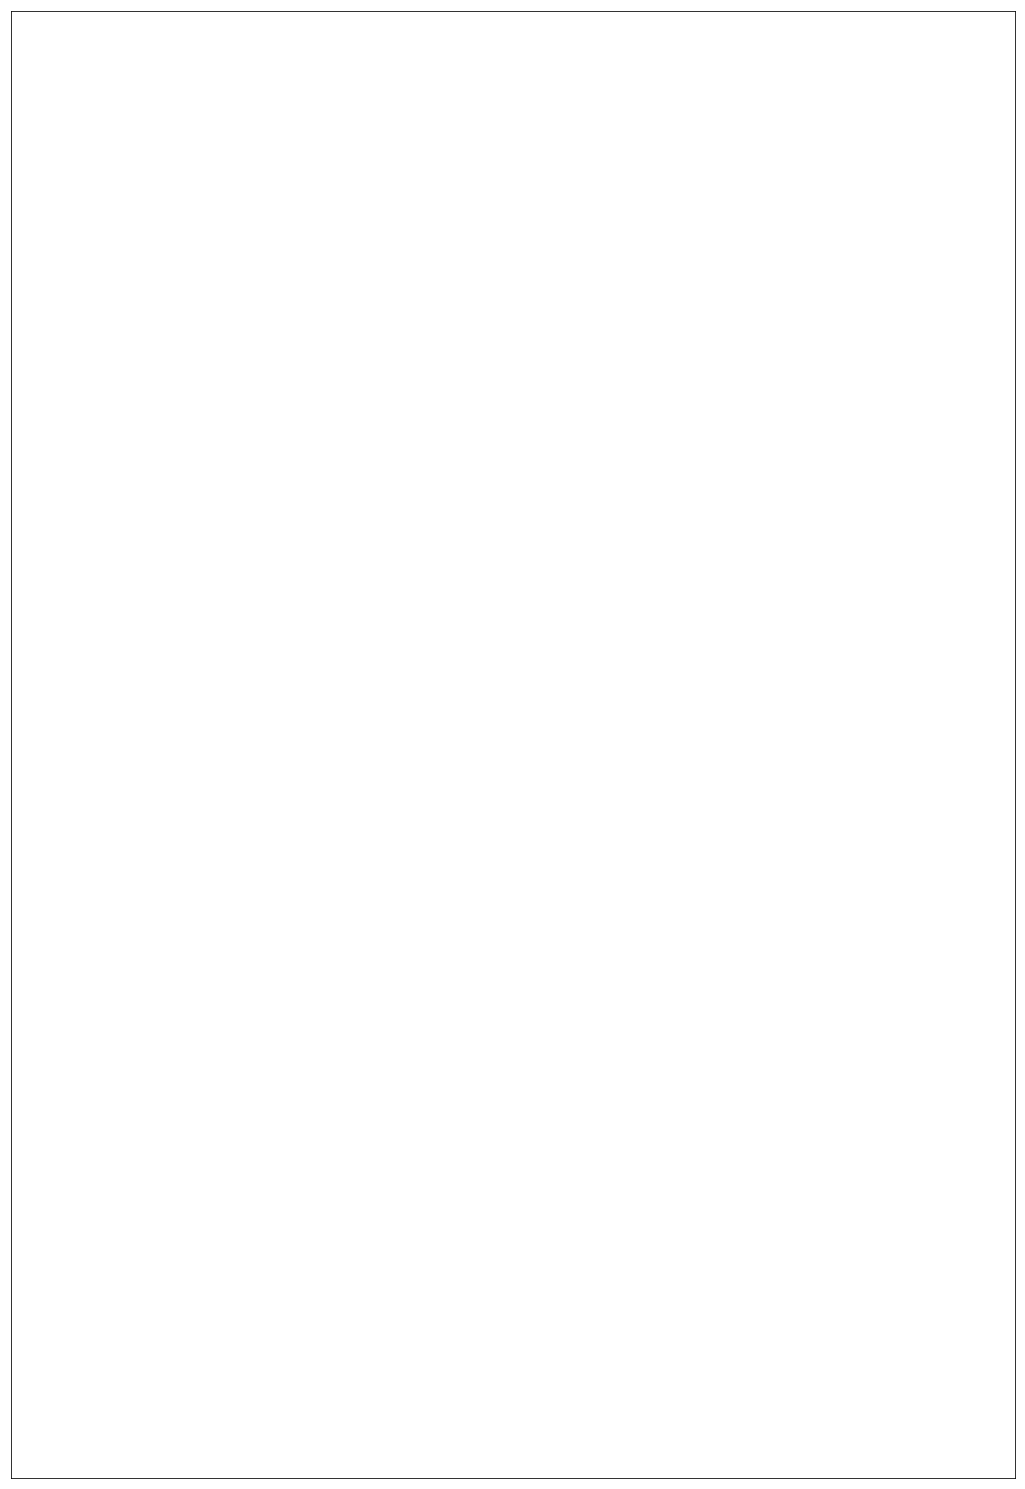

In [26]:
selectedRatiosAt = (1.25, 1.5, 2., 3.)
selectedRhosAt = (8, 12, 15, 16)
#selectedSonSchemes = (1,)
#selectedExcSchemes = (0,)
selectedTime = 1000000
rhos_theo = np.arange(2, 50)

nRows, nCols = 6, len(selectedRatiosAt)
fig = plt.figure(figsize=(4.5*(nCols), 4.5*nRows))
gs1 = matplotlib.gridspec.GridSpec(nRows, nCols)
gs1.update(wspace=0.15, hspace=0.15)

allRatios = set()
for sonExch, sonResults in sorted(ResultsTot.iteritems()):
    for sampleStrat, Results in sorted(sonResults.iteritems()):
        allRatios.update(Results.keys())

paletta = sns.color_palette("husl", len(allRatios))
colors  = [paletta[i] for i in  range(len(allRatios))]
markers = 'ov^<>8sp*hHDd'

colors  = {r: c for r, c in zip(allRatios, colors)}
markers = {r: markers[i%len(markers)] for i, r in enumerate(allRatios)}

for sonExch, sonResults in sorted(ResultsTot.iteritems()):
    #if selectedSonSchemes and sonExch not in selectedSonSchemes: continue
    for sampleStrat, Results in sorted(sonResults.iteritems()):
        #if selectedExcSchemes and sampleStrat not in selectedExcSchemes: continue
        firstPlot = True
        
        # Update the constants to compute f and p...
        AconstF, BconstF, CconstF =  tuple(f_r_p_params[sonExch][sampleStrat]["f"])
        AconstP, BconstP, CconstP =  tuple(f_r_p_params[sonExch][sampleStrat]["p"])
            
        for plot_index, ratio in enumerate(selectedRatiosAt):
            for tmp_Rho in selectedRhosAt:
                tmp_Nu = tmp_Rho / ratio

                fname = "/home/ubi/urns/data_done/Symm_SonsExchg%d_StrctSmpl%d_r%02d_n%02d_t%012d_Run_00_connections.dat" %\
                            (sonExch, sampleStrat, tmp_Rho, tmp_Nu, selectedTime)
                if not os.path.exists(fname): continue
                    
                valori = np.loadtxt(fname)
                Evolution_Steps = selectedTime

                subplot_index = (sonExch*3)*nCols + sampleStrat*nCols + plot_index
                ax = fig.add_subplot(gs1[subplot_index])
                #plt.subplot(nRows, nCols, subplot_index)
                
                XXX = valori[:,0]
                if firstPlot:
                    plt.title(r"$%s\;\, R = %.02f$" % (sonexch2strat[(sonExch, sampleStrat)], ratio), size=20)
                    line_obj = plt.loglog(XXX, valori[:,2], "-C0")
                    line_obj.extend(plt.loglog(XXX, valori[:,8], "-C1"))
                    line_obj.extend(plt.loglog(XXX, valori[:,9], "-C2"))
                    #line_obj = plt.loglog(valori[:,0], valori[:,[2,8,9]])
                    firstPlot = False
                else:
                    plt.loglog(XXX, valori[:,2], "-C0")
                    plt.loglog(XXX, valori[:,8], "-C1")
                    plt.loglog(XXX, valori[:,9], "-C2")
            
            if not firstPlot:
                firstPlot = True
                Gamma_asympt_val = (1.5*tmp_Nu)/tmp_Rho
                line_obj.extend(plt.loglog(XXX, 1.15*(XXX/XXX[-1])**Gamma_asympt_val*valori[-1,8],
                        '--C3', lw=3, label=r"$t^\gamma_t$"))

                reference_dictionary = ResultsTot[sonExch][sampleStrat][ratio]
                available_rhos = set(reference_dictionary.keys())
                max_common_rho = max(available_rhos.intersection(selectedRhosAt))
                Gamma_empirical = np.mean(reference_dictionary[max_common_rho]['D_e'])
                line_obj.extend(plt.loglog(XXX, 1.15*(XXX/XXX[-1])**Gamma_empirical*valori[-1,9],
                        '--C4', lw=3, label=r"$t^\gamma_e$"))
                
                ax.text(.25, .8, r"$\gamma_e = %.02f$" % Gamma_empirical + "\n" +
                                r"$\gamma_t = %.02f$" % Gamma_asympt_val, horizontalalignment='center',
                                verticalalignment='center', transform=ax.transAxes, fontdict=dict(size=20))
                
            if subplot_index % nCols == 0:
                plt.ylabel(r"$D(t),\,A(t),\,F(t)$", size=24)
                plt.yticks(size=22)
            else:
                plt.yticks([])
                
            if subplot_index / nCols >= nRows - 1:
                plt.xlabel(r"$t\;[ev]$", size=24)
                plt.xticks(size=22)
            else:
                plt.xticks([])

#cax = plt.axes([.925, .15, .1, .1])
lgd = plt.figlegend(line_obj, (r"$D(t)$", r"$A(t)$", r"$F(t)$", r"$t^\gamma_t$", r"$t^\gamma_e$"),
           fontsize=22, numpoints=1, loc=3, ncol=5,
           bbox_to_anchor=[.1, .025, .6, .025], mode="expand")
plt.tight_layout(rect=[0, 0.00, 1, 1.])
plt.savefig("fig_Dt_%s.pdf" % ("-".join("%d"%d for d in selectedRhosAt)),
            bbox_inches='tight', bbox_extra_artists=(lgd,))

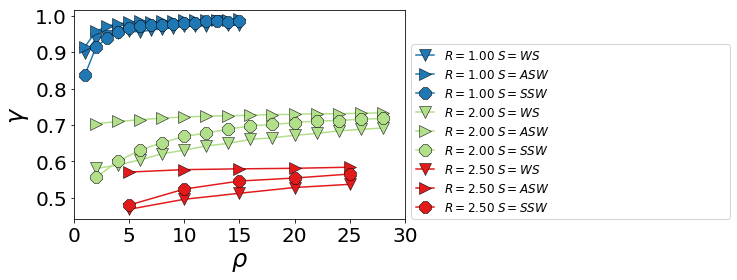

In [27]:
# Gamma comparison at different rhos, ratio and strategy...

# The params are (son, exchange, ratio)
selectedParams = [(0,1,1.0), (1,1,1.0), (1,2,1.0),
                  (0,1,2.0), (1,1,2.0), (1,2,2.0),
                  (0,1,2.5), (1,1,2.5), (1,2,2.5),
                 ]
strategyNames = {
    (0,0): "WS",
    (0,1): "WS",
    (0,2): "USW",
    (1,0): "FS",
    (1,1): "ASW",
    (1,2): "SSW",
}

markers="so^*x8pd4"
colors = "rgkcby"

# Plot the average or the longest time?
plotAverage = True
# Weight proportional to elapsed time
averageWeighted = False

file_name = "ratios_Gamma_Comparison.pdf"

rhos_theo = np.arange(2, 50)
fig, ax = plt.subplots(1,1)

allRatios = set()
for sonExch, sonResults in sorted(ResultsTot.iteritems()):
    for sampleStrat, Results in sorted(sonResults.iteritems()):
        allRatios.update(Results.keys())

paletta = sns.color_palette("Paired", len(allRatios))
colors  = [paletta[i] for i in  range(len(allRatios))]
markers = 'ov^<>8sp*hHDd'

colors  = {r: c for r, c in zip(allRatios, colors)}
#markers = {r: markers[i%len(markers)] for i, r in enumerate(allRatios)}
for (sonExch, sampleStrat, selRatio) in selectedParams:
    sonResults = ResultsTot[sonExch]
    Results = sonResults[sampleStrat]
    
    for curv_n, [ratio, res] in enumerate(sorted(Results.items())):
        if ratio != selRatio: continue

        # Update the constants to compute f and p...
        AconstF, BconstF, CconstF =  tuple(f_r_p_params[sonExch][sampleStrat]["f"])
        AconstP, BconstP, CconstP =  tuple(f_r_p_params[sonExch][sampleStrat]["p"])

        rhos = [k for k in sorted(res.keys())]

        if plotAverage:
            if averageWeighted:
                nTimes = np.array([float(len(res[k]['Ev_Steps'])) for k in rhos])
                weights = [np.array(res[k]['Ev_Steps']) for k in rhos]
            else:
                nTimes = np.array([float(len(res[k]['D_e'])) for k in rhos])
                weights = [np.ones(len(res[k]['Ev_Steps'])) for k in rhos]
            positionsIni = np.zeros(len(rhos), dtype=np.int)
            positionsFin = np.array(nTimes, dtype=np.int)
        else:
            nTimes = np.array([1 for _ in rhos])
            weights = [np.ones(1) for _ in nTimes]
            positionsIni = np.array([np.argmax(np.array(res[k]['Ev_Steps'])) for k in rhos], dtype=np.int)
            positionsFin = positionsIni + 1
        weightsSum = [np.sum(ws) for ws in weights]

        D_exps = np.array([np.sum(np.array(res[k]['D_e'][positionsIni[i]:positionsFin[i]])*weights[i])/weightsSum[i] for i,k in enumerate(rhos)])
        A_exps = np.array([np.sum(np.array(res[k]['A_e'][positionsIni[i]:positionsFin[i]])*weights[i])/weightsSum[i] for i,k in enumerate(rhos)])
        F_exps = np.array([np.sum(np.array(res[k]['F_e'][positionsIni[i]:positionsFin[i]])*weights[i])/weightsSum[i] for i,k in enumerate(rhos)])
        D_const = np.array([np.sum(np.array(res[k]['D_c'][positionsIni[i]:positionsFin[i]])*weights[i])/weightsSum[i] for i,k in enumerate(rhos)])
        A_const = np.array([np.sum(np.array(res[k]['A_c'][positionsIni[i]:positionsFin[i]])*weights[i])/weightsSum[i] for i,k in enumerate(rhos)])
        F_const = np.array([np.sum(np.array(res[k]['F_c'][positionsIni[i]:positionsFin[i]])*weights[i])/weightsSum[i] for i,k in enumerate(rhos)])

        riferimento = np.array(D_const)
        D_const /= riferimento
        F_const /= A_const
        A_const /= riferimento
        p_to_f = np.array([sum(res[k]['p_to_f'])/float(len(res[k]['p_to_f'])) for k in sorted(res.keys())])
        plt.plot(rhos, D_exps, linestyle='-', color=colors[ratio], ms=12,
                 label=r"$R=%.02f \; S=%s$"% (ratio, strategyNames[(sonExch, sampleStrat)]),\
                 marker=markers[sonExch*3 + sampleStrat], mew=.5, mec="k")
        tmp_Rho = rhos[-1]
        tmp_Nu = tmp_Rho/ratio

        prediction = (tmp_Nu - p_to_f[-1]) + (tmp_Nu + 1 - F_const[-1])*A_const[-1]
        prediction /= 2.*tmp_Rho
        rhos = np.array(rhos)

    plt.xlabel(r"$\rho$", size=24)
    plt.ylabel(r"$\gamma$", size=24)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.xlim(0,30)
    #plt.ylim(.4,1.05)

handles, labels = ax.get_legend_handles_labels()
plt.tight_layout()
plt.savefig(file_name, bbox_inches='tight')#, bbox_extra_artists=(lgd,))

plt.legend(handles, labels, fontsize=12, numpoints=1, loc=[1.02,0], ncol=1,
           mode="expand", handlelength=1.5)
plt.savefig(file_name.replace(".pdf", "_legend.pdf"), bbox_inches='tight')#, bbox_extra_artists=(lgd,))

# JUNK

In [3]:
IDIr = "/home/ubi/urns/data_analyzed/"

sonExchSchemes = range(2)
smplStrategies = range(3)

minimumTime = lambda ratio_val, rho_val: 10000 if ratio_val < 1. else 500000

ResultsTot = {}
for sonExch in sonExchSchemes:
    ResultsTot[sonExch] = {}
    for sampleStrat in smplStrategies:
        ResultsTot[sonExch][sampleStrat] = {}
        
        Results = ResultsTot[sonExch][sampleStrat]

        file_prefix = "Symm_SonsExchg%d_StrctSmpl%d_r" % (sonExch, sampleStrat)
        file_suffix = "_connections.dat"

        Factor_Analysis = './Factors_Analysis.sh'
        

        for fname in sorted(os.listdir(IDIr)):
            if not ( fname.startswith(file_prefix) and fname.endswith(file_suffix) ):
                continue

            Rho = float(fname.split("_r")[1][:2])
            Nu = float(fname.split("_n")[1][:2])
            Ratio = Rho/Nu
            Evolution_Steps = int(fname.split("_t")[-1].split("_")[0])
            if Evolution_Steps < minimumTime(Ratio, Rho):
                continue

            fname = os.path.join(IDIr, fname)
            args = [Factor_Analysis, fname]
            P  = Popen(args, stdout=PIPE, stderr=PIPE)
            out, err = P.communicate()

            if err:
                print err

            str2float = lambda s: float(s.replace(",", "."))
            out = out.splitlines()
            for line_num, line in enumerate(out):
                if "DTexp" in line:
                    DT_exp = str2float(out[line_num+1])
                elif "ATexp" in line:
                    AT_exp = str2float(out[line_num+1])
                elif "FTexp" in line:
                    FT_exp = str2float(out[line_num+1])
                elif "PToFATH" in line:
                    PtoF_const = str2float(out[line_num+1])
                elif "LAST TIME VALS" in line:
                    vals = out[line_num+1].split()
                    [DT_const, AT_const, FT_const] = [str2float(vals[i]) for i in [2,8,9]]

            if False:
                print "\n###################################\n"
                print "File: ", fname
                print "Ratio: ", Ratio, " rho ", Rho, " nu ", Nu, " Steps ", Evolution_Steps
                print "D(t): ", DT_const, DT_exp
                print "A(t): ", AT_const, AT_exp
                print "F(t): ", FT_const, FT_exp
                print "p(t): ", PtoF_const
                print "\n###################################\n"


            Results.setdefault(Ratio, {})
            Results[Ratio].setdefault(Rho, {'D_c': [], "D_e": [], "A_c": [], "A_e": [],\
                                            "F_c": [], "F_e": [], "p_to_f": [], "Ev_Steps": []})
            Results[Ratio][Rho]['D_c'].append(DT_const)
            Results[Ratio][Rho]['D_e'].append(DT_exp)
            Results[Ratio][Rho]['A_c'].append(AT_const)
            Results[Ratio][Rho]['A_e'].append(AT_exp)
            Results[Ratio][Rho]['F_c'].append(FT_const)
            Results[Ratio][Rho]['F_e'].append(DT_exp)
            Results[Ratio][Rho]['p_to_f'].append(PtoF_const)
            Results[Ratio][Rho]['Ev_Steps'].append(Evolution_Steps)
    
    print sonExch

Data have non-positive values

0
Data have non-positive values

1


In [4]:
print "DONE!"

DONE!
